In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import vivarium, vivarium.test_util as vtu
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns
import pandas as pd
import json

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models.cohort_analysis_function as caf

In [3]:
n_simulants = 1500
n_days = 365
t_start = pd.Timestamp('2017-01-01')
t_timestep = 1
with open('../data/processed/p_return.json') as data_file:    
    return_rates = json.load(data_file)

## Simulate the cohort

In [101]:
class HIVCohortFollowUp:
    def __init__(self , return_rates):
        self.reports = {}
        self.return_rates = return_rates
        self.current_database = pd.DataFrame({'visit_date':[] , 'next_visit_date':[] })
    
    @listens_for('initialize_simulants')
    @uses_columns(['state', 'next_visit_date', 'first_visit','follow_up_duration'])
    def initialize(self, event):
        # create the population dataframe
        population = pd.DataFrame(index=event.index)
        population['state'] = 'Out' #Followed, LTFU, Dead,   
        population['next_visit_date'] = pd.NaT
        population['follow_up_duration'] = 0
        
        # Give first visit
        first_visit = np.round(np.random.uniform(0, 365, n_simulants))
        population['first_visit'] = t_start + pd.to_timedelta(first_visit, 'D')
        
        # Give first follow up
        rows = np.random.binomial(1, 0.5, size=len(population))
        population['next_visit_date'] = population['first_visit'] + pd.Timedelta(days=7*4)
        
        population.loc[population['first_visit'] == t_start , 'state'] = 'Followed'
        
        # update the population in the model
        event.population_view.update(population)
        
    @listens_for('time_step')
    @uses_columns(['state', 'first_visit', 'next_visit_date'], 'state == "Out"')
    def new_patients(self, event):
        df = event.population
        df.loc[df['first_visit'] == event.time, 'state'] = 'Followed'
        df.loc[df['first_visit'] == event.time, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        n_new = len(df.loc[df['first_visit'] == event.time])
        self.current_database = self.current_database.append(pd.DataFrame({'visit_date':[event.time]*n_new, 
                                                                          'next_visit_date':df.loc[df['first_visit'] == event.time, 
                                                                                                   'next_visit_date']} , 
                                                             index = df.index[df['first_visit'] == event.time]))
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state', 'next_visit_date'], 'state != "Out"')
    def next_appointment(self, event):
        df = event.population
        df.visit_delay = (event.time - df['next_visit_date'])/ np.timedelta64(1, 'D')
        
        ordered_change_times = sorted(list(map(int , self.return_rates.keys())))
        
        min_chunk = str(ordered_change_times[0])
        chunk_1 = df[df.visit_delay <= float(min_chunk)]
        visit = np.random.binomial(1, self.return_rates[min_chunk], size=len(chunk_1))
        visitors = list(chunk_1.index[visit == 1])
        
        for i in range(1,len(ordered_change_times) - 1):
            chunk = str(ordered_change_times[i])
            chunk_i = df[(df.visit_delay > float(min_chunk)) & (df.visit_delay <= float(chunk))]
            visit = np.random.binomial(1, self.return_rates[chunk], size=len(chunk_i))
            visitors_i = list(chunk_i.index[visit == 1])
            visitors = visitors + visitors_i
            min_chunk = chunk
            
        max_chunk = str(ordered_change_times[len(ordered_change_times) - 1])
        chunk_n = df[df.visit_delay > float(max_chunk)]
        visit = np.random.binomial(1, self.return_rates[max_chunk], size=len(chunk_n))
        visitors_n = list(chunk_n.index[visit == 1])
        visitors = visitors + visitors_n
        
        n_visitors = len(visitors)
        
        df.loc[visitors, 'next_visit_date'] = event.time + pd.Timedelta(days=7*4)
        if n_visitors > 0 :
            self.current_database = self.current_database.append(
                pd.DataFrame({'visit_date':[event.time]*n_visitors,
                              'next_visit_date': df.loc[visitors, 'next_visit_date']} ,
                             index = list(df.loc[visitors].index)))
        
        df.visit_delay = (event.time - df['next_visit_date'])/ np.timedelta64(1, 'D')
        df.loc[df.visit_delay > 90 , 'state'] = 'LTFU'
        df.loc[df.visit_delay <= 90 , 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state'], 'state != "Out"')
    def export_report_datapoint(self, event):
        date = event.time
        self.reports[date] = event.population.state.value_counts()

In [102]:
components = [HIVCohortFollowUp(return_rates)]
vtu.config.simulation_parameters.time_step = 1/365
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

365

In [103]:
print(simulation.population.population.state.value_counts());
print(simulation.population.population.state.value_counts() / len(simulation.population.population));

Followed    1246
LTFU         254
Name: state, dtype: int64
Followed    0.830667
LTFU        0.169333
Name: state, dtype: float64


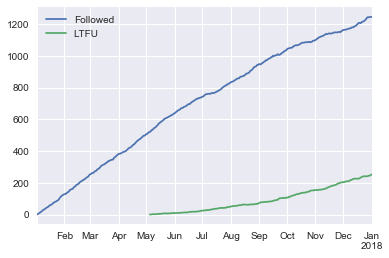

In [104]:
report_out = pd.DataFrame.from_dict(components[0].reports , orient='index')
report_out.plot()

In [105]:
full_database = components[0].current_database.copy()

## Simulate Data Entry

77.0


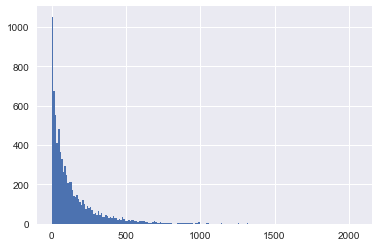

In [106]:
s = np.random.weibull(.8, len(full_database))
u = np.round(s*365/3)
print(np.median(u))
plt.hist(u , bins=200);

In [107]:
full_database['delta'] = pd.to_timedelta(u , 'days')
full_database['date_entered'] = full_database.visit_date + full_database.delta

In [108]:
full_database['patient_id']= full_database.index

In [109]:
full_database = full_database.reset_index()

In [110]:
full_database['reasonDescEn'] = np.nan
full_database['discDate'] = pd.NaT

In [111]:
#full_database.columns = ['next_visit_date', 'visit_date', 'delta', 'date_entered']
def get_first_visit_date(data_patient):
    data_patient['first_visit_date'] = min(data_patient.visit_date)
    return data_patient

d = full_database.groupby('patient_id').apply(get_first_visit_date)

In [114]:
def status_patient(data_patient, reference_date, analysis_date, grace_period):
    ''' Determines the status of a patient at a given reference_date, given the data available at a given analysis_date
    TODO Also select the available data for Death and Transfer and other
    '''
    data_current = data_patient[data_patient.date_entered < analysis_date]
#    print(data_current)
    reference_date = pd.to_datetime(reference_date)
 #   status = ''
    if len(data_current) > 0:
        date_last_appointment = data_current.next_visit_date.max()
        date_last_appointment = pd.to_datetime(date_last_appointment)
        late_time = reference_date - date_last_appointment
        if late_time.days > grace_period:
            status = 'LTFU'
        if late_time.days <= grace_period:
            status = 'Followed'
        if (data_current.reasonDescEn.iloc[0] is not np.nan) & \
        (pd.to_datetime(data_current.discDate.iloc[0]) < reference_date):
            status = data_current.reasonDescEn.iloc[0]
        return pd.DataFrame([{'status': status,
                              'late_time': late_time,
                              'last_appointment': date_last_appointment,
                              'reference_date': reference_date,
                              'analysis_date': analysis_date}])

In [118]:
out = d.groupby(d.patient_id).apply(status_patient, reference_date = '2018-01-01', 
                    analysis_date = '2018-01-01', grace_period = 90)

In [119]:
out.status.value_counts()

Followed    893
LTFU        380
Name: status, dtype: int64

In [131]:
out = out.reset_index()

In [132]:
out.head()

,patient_id,level_1,analysis_date,last_appointment,late_time,reference_date,status
0,0,0,2018-01-01,2017-08-19,135 days,2018-01-01,LTFU
1,1,0,2018-01-01,2017-12-26,6 days,2018-01-01,Followed
2,2,0,2018-01-01,2017-10-11,82 days,2018-01-01,Followed
3,3,0,2018-01-01,2017-09-05,118 days,2018-01-01,LTFU
4,5,0,2018-01-01,2017-11-14,48 days,2018-01-01,Followed


In [134]:
for i in list(d.patient_id):
    if i not in list(out.patient_id) :
        print(i)

942
809
1329
257
301
301
585
685
1121
301
578
1414
172
285
301
35
1388
1164
695
1199
593
599
1442
260
469
172
712
469
683
1232
599
89
1208
533
695
761
1199
99
425
1308
824
593
628
1313
1313
35
378
697
714
172
1361
660
138
1222
938
712
512
676
1387
683
751
512
23
65
76
123
695
889
903
1297
274
1471
714
948
425
1199
35
1388
51
1058
1131
1222
891
697
1313
831
977
4
561
1163
103
890
695
327
1213
889
138
1247
1408
683
712
172
660
1117
1496
508
662
1490
676
761
219
932
1000
1460
1131
35
58
522
931
76
512
193
621
1494
1471
188
1076
1087
285
428
1232
546
1164
994
1495
123
691
945
1117
1388
703
1125
1479
791
1141
1208
1260
23
1329
694
1490
948
181
888
1360
1413
1420
945
1297
104
553
896
181
51
1058
274
1107
831
891
242
507
1407
1454
51
1087
890
166
486
1054
1059
1070
425
938
763
981
1045
1329
1213
561
1498
219
695
360
1219
327
889
103
1439
712
1247
322
535
677
1479
315
393
447
546
181
41
226
1407
676
761
472
837
1043
1205
791
1131
1460
593
478
852
1152
896
1388
931
97
665
698
1198
1356
285
512


In [136]:
d[d.patient_id == 809]

,index,next_visit_date,visit_date,delta,date_entered,patient_id,reasonDescEn,discDate,first_visit_date
375,809,2017-03-26,2017-02-26,426 days,2018-04-28,809,NaN,NaT,2017-02-26
